In [25]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
from graphviz import Digraph

def trace(root):
  """Builds a set of all nodes and edges in a graph."""
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  """Creates a Digraph representation of the graph."""
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it.
    dot.node(name=uid, label="{ %s | data %.4f | grad % .4f }" % (n.label, n.data, n.grad), shape="record")

    if n._op:
      # If this value is a result of some operation, create an op node.
      dot.node(name=uid + n._op, label=n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # Connect nl to the op node of n2.
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [27]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    

        return out

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float power for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    # https://en.wikipedia.org/wiki/Hyperbolic_functions
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        # topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1  # initialize
        for node in reversed(topo):
            node._backward()    

In [28]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

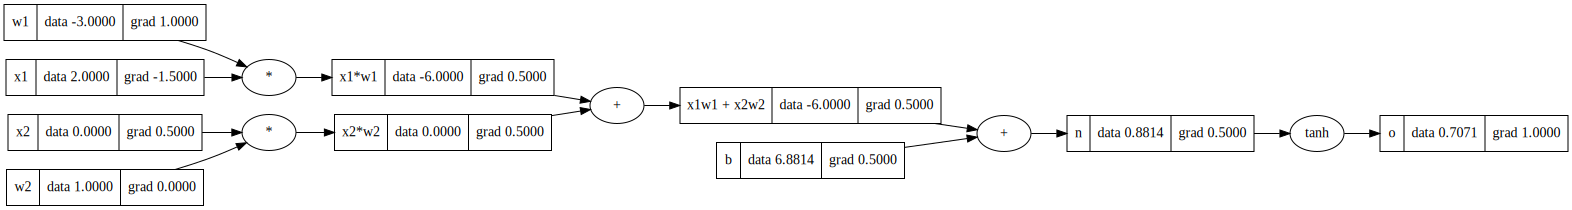

In [29]:
draw_dot(o)

In [46]:
# https://en.wikipedia.org/wiki/Hyperbolic_functions
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
#----------
# o = n.tanh(); o.label = 'o'
e = (2*n).exp()
o = (e - 1) / (e + 1)
#----------
o.backward()

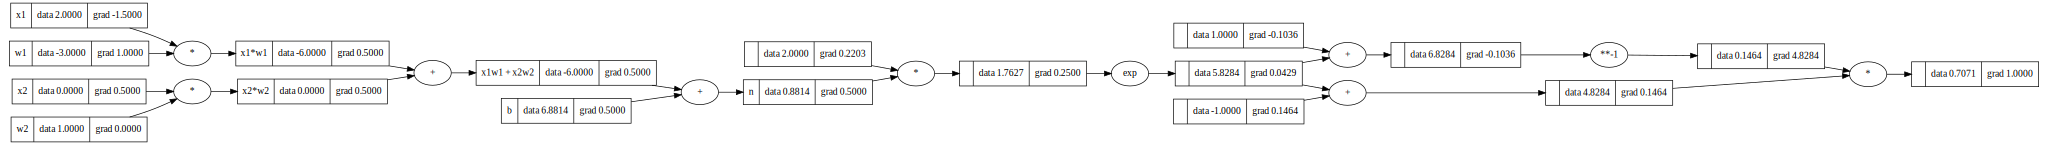

In [47]:
draw_dot(o)

In [53]:
# https://en.wikipedia.org/wiki/Hyperbolic_functions
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
#----------
# o = n.tanh(); o.label = 'o'
e = (2*n).exp()
o1 = (e - 1) / (e + 1)
#----------
o1.backward()

h = 0.0001
x1 += h
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o2 = (e - 1) / (e + 1)
o_grad = (o2 - o1) / h 

print(f'o_grad = {o_grad}')

o_grad = Value(data = -1.5003182205530763)


In [32]:
import torch

In [33]:
x1 = torch.Tensor([2.0]).double()               ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ;w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ;b.requires_grad  = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(f'o.data.item() = {o.data.item()}')
o.backward()

print('--------')
print('x2.grad.item() = ', x2.grad.item())
print('w2.grad.item() = ', w2.grad.item())
print('x1.grad.item() = ', x1.grad.item())
print('w1.grad.item() = ', w1.grad.item())

o.data.item() = 0.7071066904050358
--------
x2.grad.item() =  0.5000001283844369
w2.grad.item() =  0.0
x1.grad.item() =  -1.5000003851533106
w1.grad.item() =  1.0000002567688737


In [34]:
import random

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x)), self.b)
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):


        # print(f'w: {self.w}, b: {[self.b]}')

        
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x        

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        params = []
        # for layer in self.layers:
        #     ps = layer.parameters()
        #     params.extend(ps)
        # return params

In [35]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data = 0.44270027682749263)

In [36]:
print(f'len(n.parameters()): {len(n.parameters())}')
n.parameters()

len(n.parameters()): 41


[Value(data = 0.6414801864246764),
 Value(data = -0.2604880649149588),
 Value(data = 0.7594378033419058),
 Value(data = -0.39339493539565473),
 Value(data = -0.4582944964522495),
 Value(data = -0.9490132026977867),
 Value(data = 0.334398130856534),
 Value(data = -0.5216669918744188),
 Value(data = -0.9875005527954306),
 Value(data = 0.6878885839207511),
 Value(data = -0.09419111726074925),
 Value(data = -0.7537933604707694),
 Value(data = -0.05170800412772736),
 Value(data = -0.46428936015646904),
 Value(data = 0.31440219732136754),
 Value(data = -0.6868283997686222),
 Value(data = 0.9968081740362968),
 Value(data = 0.07257020390714963),
 Value(data = -0.45352227118151234),
 Value(data = 0.004533845450631402),
 Value(data = 0.9052426772864064),
 Value(data = -0.5092579841142362),
 Value(data = -0.6587889555491613),
 Value(data = -0.29658923345963206),
 Value(data = 0.2801790105687705),
 Value(data = -0.3609103386395931),
 Value(data = 0.35662579478759615),
 Value(data = -0.638862582338

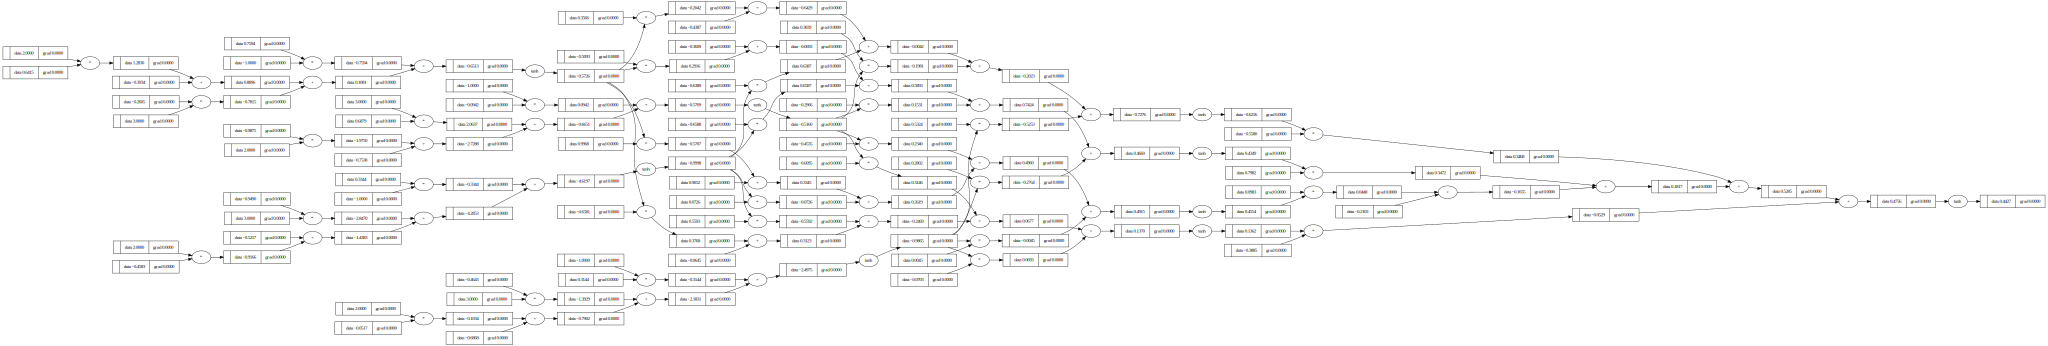

In [37]:
draw_dot(n(x))

In [38]:
# initialize neutral net, 3 inputs, 4 neurons, 4 neurons, 1 output, with random weights and bias
n = MLP(3, [4, 4, 1])

In [39]:
# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0]    
]
  
# desired targets
ys = [1.0, -1.0, -1.0, 1.0]  

In [40]:
learning_rate = 0.05

for k in range(20):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0

  # backward pass
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = -0.775603758849165), Value(data = -0.5928106697334095), Value(data = -0.7138812546068148), Value(data = -0.6956939753361144)]
step: 0, loss: 6.2758138535788035
-------
ypred: [Value(data = -0.30762406628950534), Value(data = -0.31863485977358774), Value(data = -0.3460985187120529), Value(data = -0.2803015082448935)]
step: 1, loss: 4.240898252299979
-------
ypred: [Value(data = 0.43397445992996614), Value(data = 0.0664400178279296), Value(data = 0.1840452536739515), Value(data = 0.2544922167011494)]
step: 2, loss: 3.415424241343386
-------
ypred: [Value(data = 0.14021933620294738), Value(data = -0.30843893282383406), Value(data = -0.20928728097403207), Value(data = -0.09712786263853923)]
step: 3, loss: 3.046395650480387
-------
ypred: [Value(data = 0.47393492091313116), Value(data = -0.061290067434542725), Value(data = -0.03834766154550889), Value(data = 0.2714825252092342)]
step: 4, loss: 2.613433736062224
-------
ypred: [Value(data = 0.3022527080383601), Value(dat

In [41]:
n.parameters()

[Value(data = -0.3711888402046468),
 Value(data = -0.01961188149059021),
 Value(data = 1.310597121349528),
 Value(data = -0.4071507806882235),
 Value(data = 0.7788332625016724),
 Value(data = 0.18185146017348985),
 Value(data = -0.4674911500471655),
 Value(data = 0.04777355145392361),
 Value(data = -0.4403953703820157),
 Value(data = 1.1563511759979124),
 Value(data = 0.645156782194549),
 Value(data = 0.6127509111037671),
 Value(data = 0.8383715609613457),
 Value(data = 0.810114605101672),
 Value(data = 0.32755803448082527),
 Value(data = 0.029453193983593536),
 Value(data = 0.45923185507185815),
 Value(data = -0.7293586601311312),
 Value(data = -0.8520212779447102),
 Value(data = 0.4085456649509757),
 Value(data = 0.5328214721580008),
 Value(data = -0.9819341899061975),
 Value(data = 0.4660978659834808),
 Value(data = 0.7427719126272887),
 Value(data = -0.4709380156494309),
 Value(data = -0.658862916827774),
 Value(data = 0.3302504825052771),
 Value(data = -0.2017458863910131),
 Value

In [42]:
print(f'n.layers[0].neurons[0].w[0].data = {n.layers[0].neurons[0].w[0].data}')
print(f'n.layers[0].neurons[0].w[0].grad = {n.layers[0].neurons[0].w[0].grad}')

n.layers[0].neurons[0].w[0].data = -0.3711888402046468
n.layers[0].neurons[0].w[0].grad = -0.1673546667147579


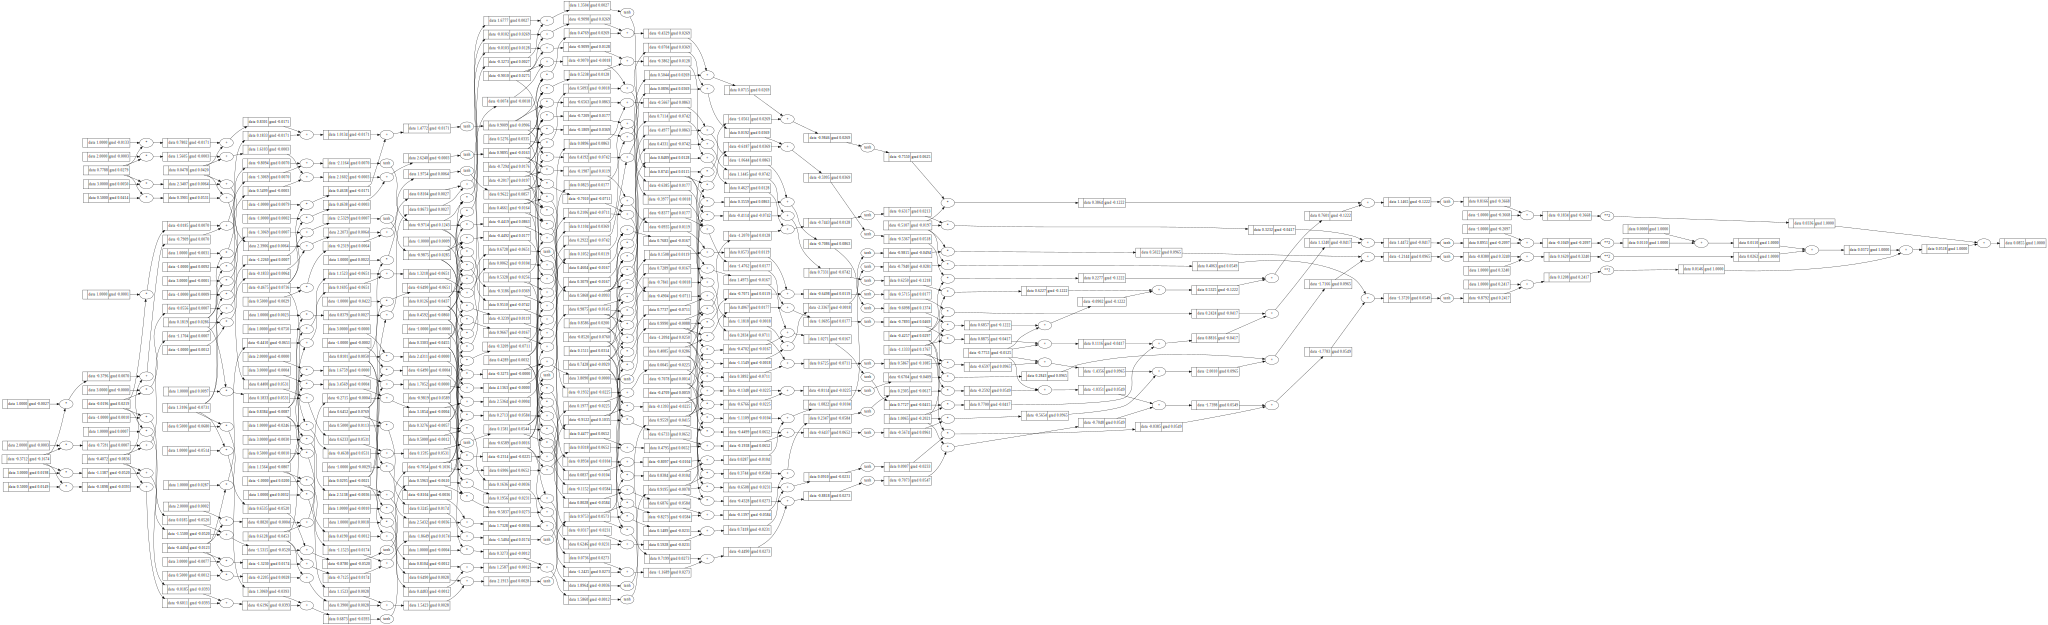

In [43]:
draw_dot(loss)

In [44]:
def lol():  # calculate gradients

  h = .0001

  a = Value(2, label='a')
  b = Value(-3, label='b')
  c = Value(10, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2, label='f')
  L = d * f; L.label='L'
  L1 = L.data

  # add h to variables to get gradient
  a = Value(2, label='a')
  # a.data += h  # dL/da
  b = Value(-3, label='b')
  b.data += h  # dL/db
  c = Value(10, label='c')
  # c.data += h  # dL/dc
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  # d.data += h  # dL/dd
  f = Value(-2, label='f')
  L = d * f; L.label='L'
  L2 = L.data

  print(f'(L2 -L1)/h = {(L2 -L1)/h}')

lol()
        

(L2 -L1)/h = -4.000000000008441


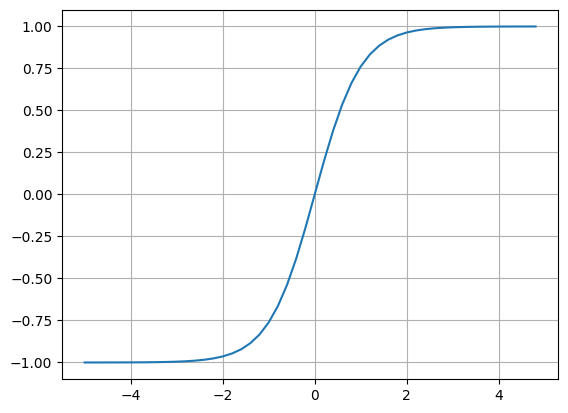

In [45]:
_num = np.arange(-5, 5, 0.2)
plt.plot(_num, np.tanh(_num))
plt.grid()